In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
from keras.callbacks import ModelCheckpoint
import pandas as pd
import csv
import pickle
from os.path import isfile, join
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


### Load data generator and list of attributes

In [2]:
dataset_path = './cropped/'
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(dataset_path, target_size=(128,128), batch_size=20, class_mode='input')

Found 212593 images belonging to 1 classes.


In [2]:
df=pd.read_csv("./list_attr_celeba.csv")
attributes = df.columns.values[1:]

### Define VAE architecture

In [3]:
img_shape = (128, 128, 3)
latent_dim = 400

input_img = keras.Input(shape=img_shape) 

x = layers.Conv2D(64, 5, padding='same', activation='relu', strides=(2,2))(input_img)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(256, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(512, 5, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(1024, 2, padding='same', activation='relu', strides=(2,2))(x)
x = layers.BatchNormalization()(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x) 

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x) 
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(1024, 2, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(512, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(256, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(128, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(64, 5, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(3, 5, padding='same', activation='sigmoid')(x)
decoder = Model(decoder_input, x)
encoder = Model(input_img, z)
z_decoded = decoder(z) 

def vae_loss(input_img, z_decoded):
    input_img = K.flatten(input_img)
    z_decoded = K.flatten(z_decoded)
    xent_loss = keras.metrics.binary_crossentropy(input_img, z_decoded) 
    kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

vae = Model(input_img, z_decoded)
vae.compile(optimizer='adam', loss=vae_loss)

Instructions for updating:
Colocations handled automatically by placer.


### Train model or load weights

In [4]:
trained = 1

if(trained == 0):
    checkpointer = ModelCheckpoint(filepath='checkpoint.hdf5', verbose=2, save_best_only=False, save_weights_only=True)
    vae.fit_generator(train_generator,
        shuffle=True,
        steps_per_epoch = 10000,
        epochs=15,
        callbacks=[checkpointer],
        verbose=1
        )
else:
    vae.load_weights('checkpoint_celeba_cropped400.hdf5')

### Obtain concept vectors

In [ ]:
latent_generator = datagen.flow_from_directory('cropped', target_size=(128,128), batch_size=100, shuffle=False)
filenames = latent_generator.filenames #list of filenames which matches list of latent vectors
latent = encoder.predict_generator(latent_generator, steps = 2000) 

num_samples = 500 #defines number of latent vectors used in averaging to obtain concept vector

# for each attribute two lists are created which contain all the pictures which either have this attribute or do not

avg_pos = []
avg_neg = []

idxs_pos = []
idxs_neg = []

for attr in attributes: 
    
    #lists to save indices of images with or without a certain attribute
    pos = []
    neg = []
    
    print(attr)
    
    for i in range(0, 180000):
        image_id = int(filenames[i][7:13])
        label = df[attr][image_id-1] # -1 to compensate zeroth row in df (indexing via row name is much slower) 
        
        #check labels for each picture and add to one of the lists accordingly
        if(label == 1):
            pos.append(i) 
        if(label == -1):
            neg.append(i)
        
    idxs_pos.append(pos)
    idxs_neg.append(neg)

    vectors_pos = latent[pos]
    vectors_neg = latent[neg]
    
    attr_avg_pos = np.average(vectors_pos[0:num_samples], axis = 0)
    attr_avg_neg = np.average(vectors_neg[0:num_samples], axis = 0)
    
    avg_pos.append(attr_avg_pos)
    avg_neg.append(attr_avg_neg)
    
avg_pos = np.array(avg_pos)
avg_neg = np.array(avg_neg)

concept_vectors = avg_pos - avg_neg

idx_pos = np.array(idxs_pos)
idx_neg = np.array(idxs_neg)

### Dot products and histograms

In [ ]:
dotp_pos = []
dotp_neg = []
concept_vectors = np.load('concept_vectors.npy')
for i, attr in enumerate(attributes):
    print(attr)
    
    vectors_pos = latent[idxs_pos[i]]
    vectors_neg = latent[idxs_neg[i]]

    dotp_pos_attr = [np.sum(concept_vectors[i]*j) for j in vectors_pos]
    dotp_neg_attr = [np.sum(concept_vectors[i]*j) for j in vectors_neg]
    
    dotp_pos.append(dotp_pos_attr)
    dotp_neg.append(dotp_neg_attr)

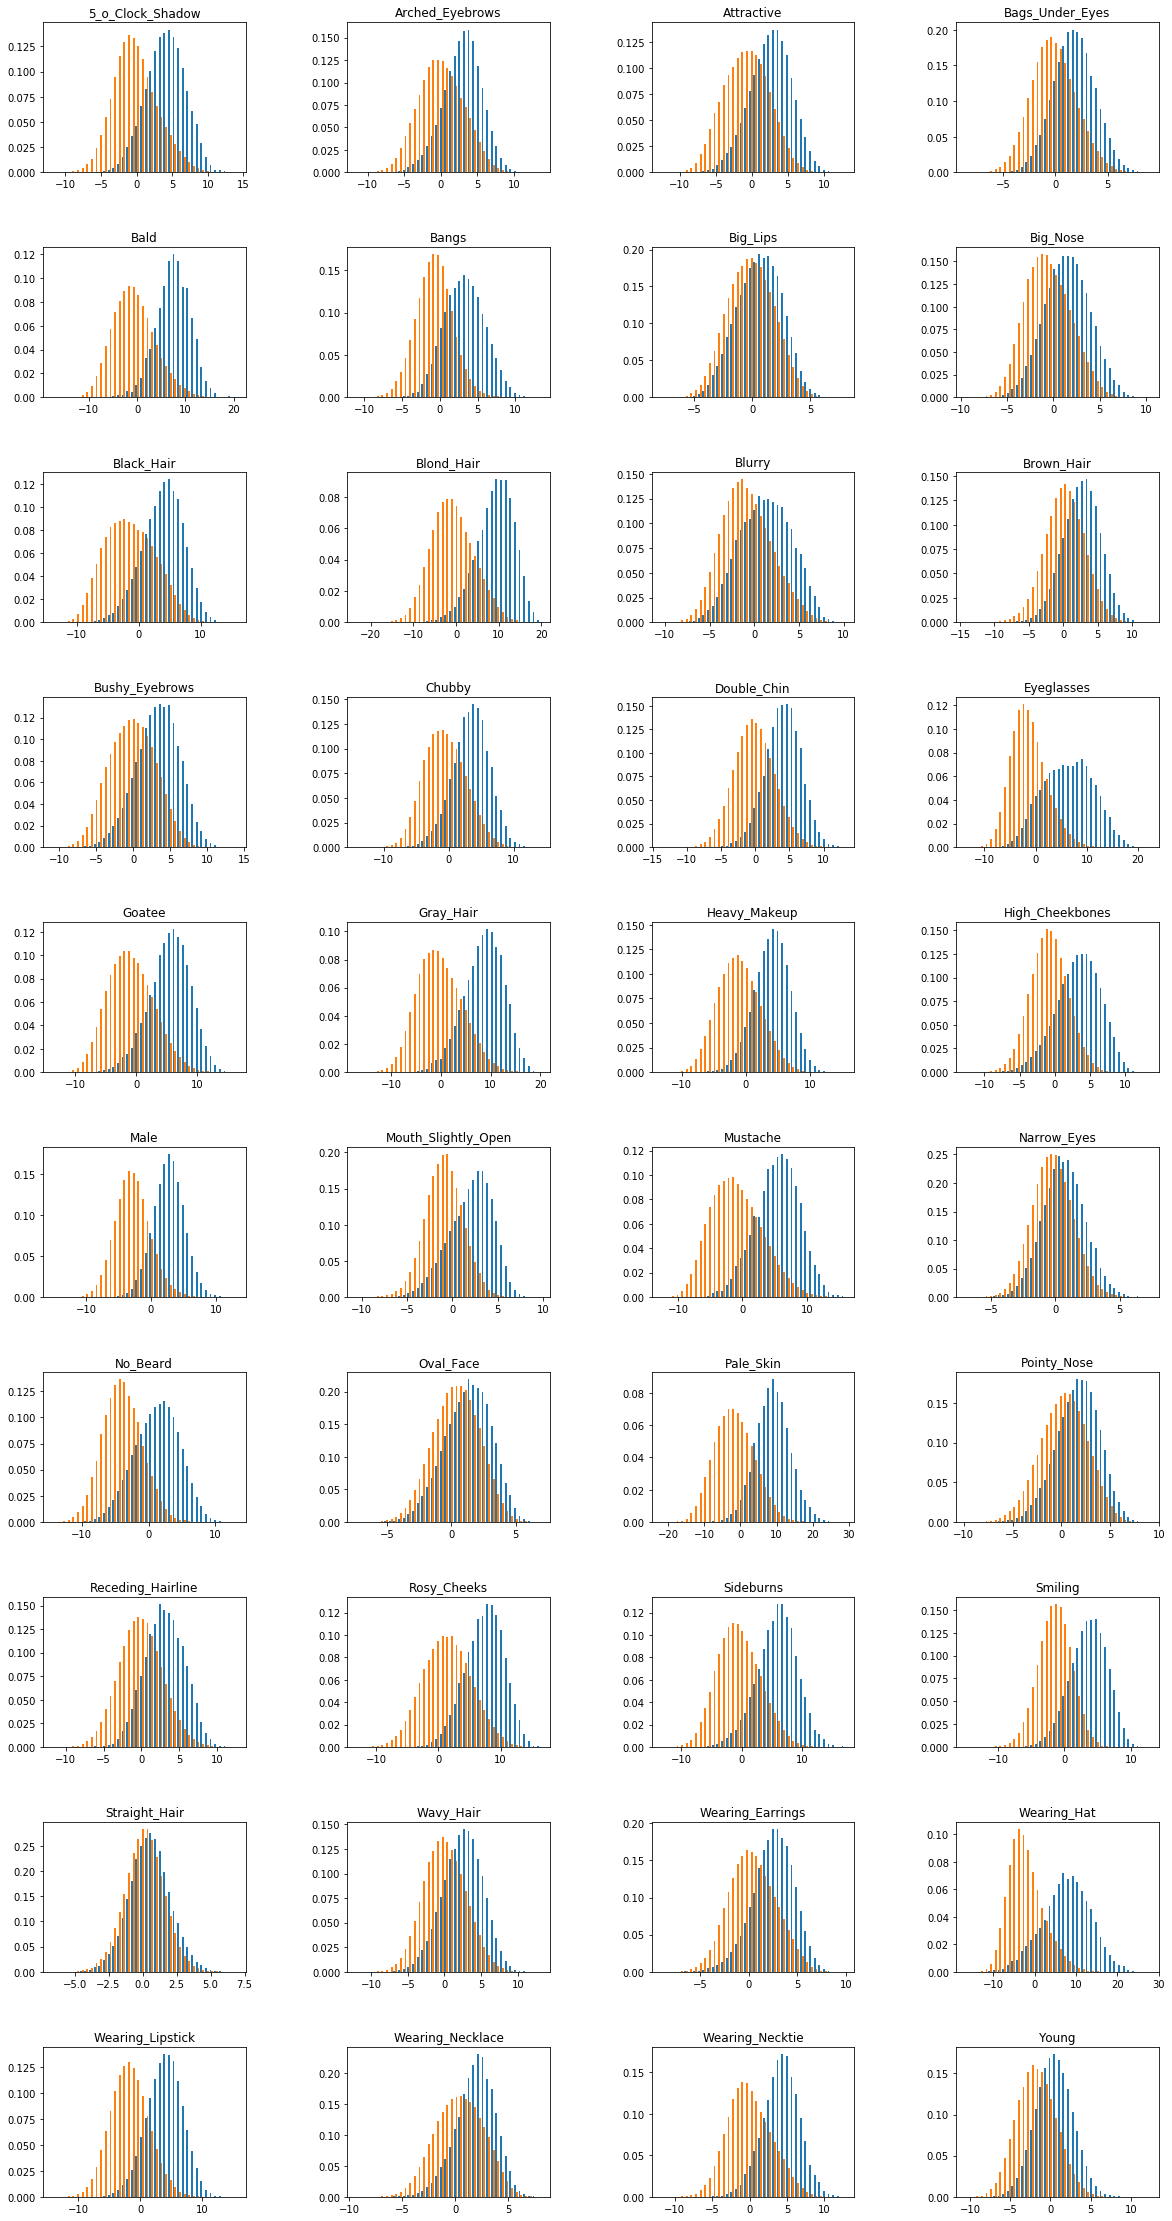

In [217]:
f, axs = plt.subplots(10,4, figsize=(20,40))

i = 0

for row in range(10):
    for column in range(4):
        axs[row, column].hist([dotp_pos[i], dotp_neg[i]], 40, density=True) 
        axs[row, column].title.set_text(attributes[i])
        i +=1

plt.subplots_adjust(hspace=0.5, wspace=0.5)

### Obtaining concept saliency maps

In [172]:
#choose image with highest dot products for saliency maüs
dotp_max = [list(reversed(np.array(i).argsort()))[2] for i in dotp_pos] 

In [189]:
files_max = []
for i, attr in enumerate(attributes):
    files_max.append(filenames[idxs_pos[i][dotp_max[i]]])
files_max = np.array(files_max)

In [218]:
#choose the attributes for which to plot saliency maps 
attr = [4,12,15,21,31,35]

In [219]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

imgs = [load_img('cropped/'+i, target_size=(128, 128)) for i in files_max[attr]]
img_array = [img_to_array(i)/255.0 for i in imgs]

In [220]:
### rectified gradient
sess = K.get_session()
from deepexplain.tensorflow import DeepExplain
from utils import preprocess, pixel_range

#the implementation of the saliency map methods are taken from https://github.com/1202kbs/Rectified-Gradient
#de.explain(method, concept_score, input_tensor, img_array)
#available methods are:     
#    'rectgrad'
#    'rectgradprr'
#    'rectgradconst'
#    'saliency
#    'grad*input'
#    'deconv'
#    'guidedbp'
#    'smoothgrad'
#    'intgrad' (Integrated Gradients)
#    'elrp'    (EpsilonLRP)
#    'deeplift'
#    'occlusion'
#    'rectgradmod'
# input_tensor: placeholder tensor 
# img_array: contains the images which are fed into input_tensor

with DeepExplain(session=sess, graph=sess.graph) as de:
    
    input_tensor = input_img
    method = 'guidedbp'
    
    lats = encoder(input_tensor)

    concept_score = [K.sum(lats*i) for i in concept_vectors[attr]]
    attributions_guided = [de.explain(method, i, input_tensor, img_array) for i in concept_score]

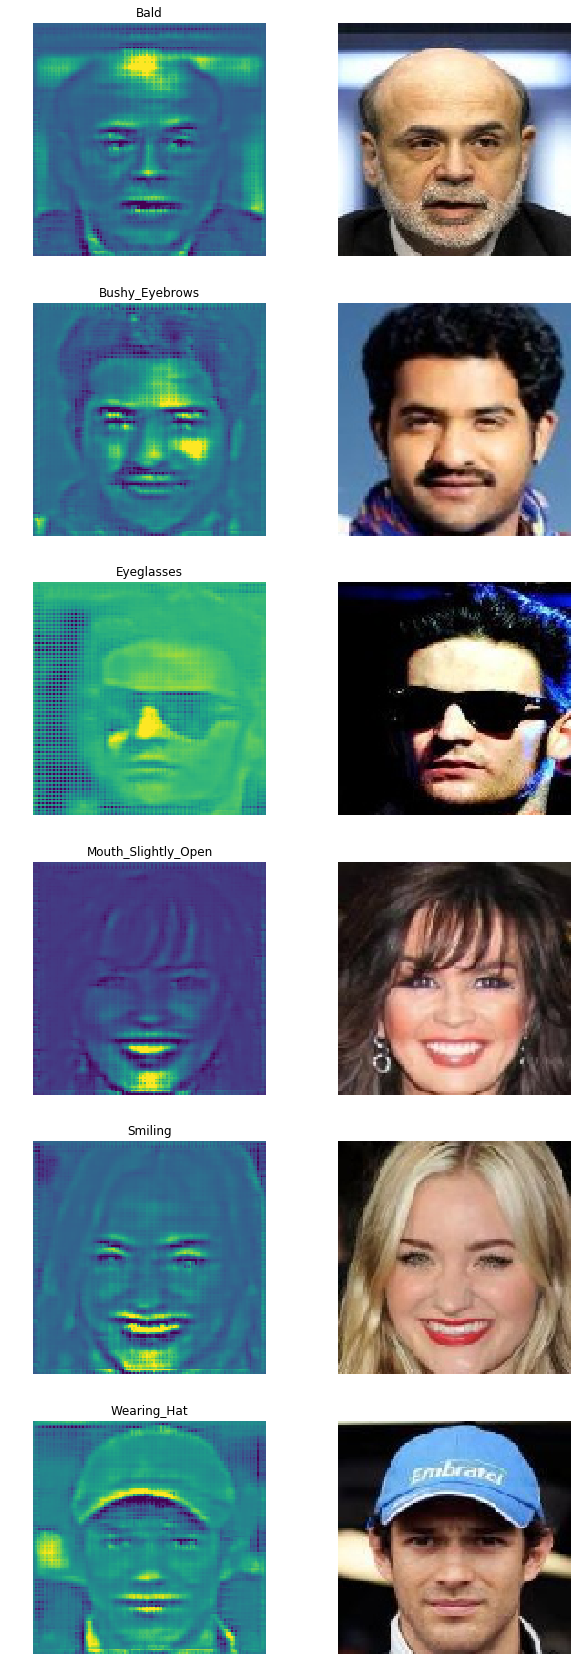

In [221]:
f, axs = plt.subplots(6,2,figsize=(10,30))

for j, attributions in enumerate(attributions_guided):
    axs[j,0].imshow(preprocess(attributions,0.5,99.5)[j])
    axs[j,1].imshow(img_array[j])
    axs[j,0].axis('off')
    axs[j,1].axis('off')
    axs[j,0].title.set_text(attributes[attr[j]])

In [222]:
with DeepExplain(session=sess, graph=sess.graph) as de:
    
    k = 90
    input_layer = input_img
    img = img_array
    method = 'rectgrad'
    
    lats = encoder(input_layer)

    class_neurons = [K.sum(lats*i) for i in concept_vectors[attr]]
    attributions_rect = [de.explain(method, i, input_layer, img, percentile=k) for i in class_neurons]

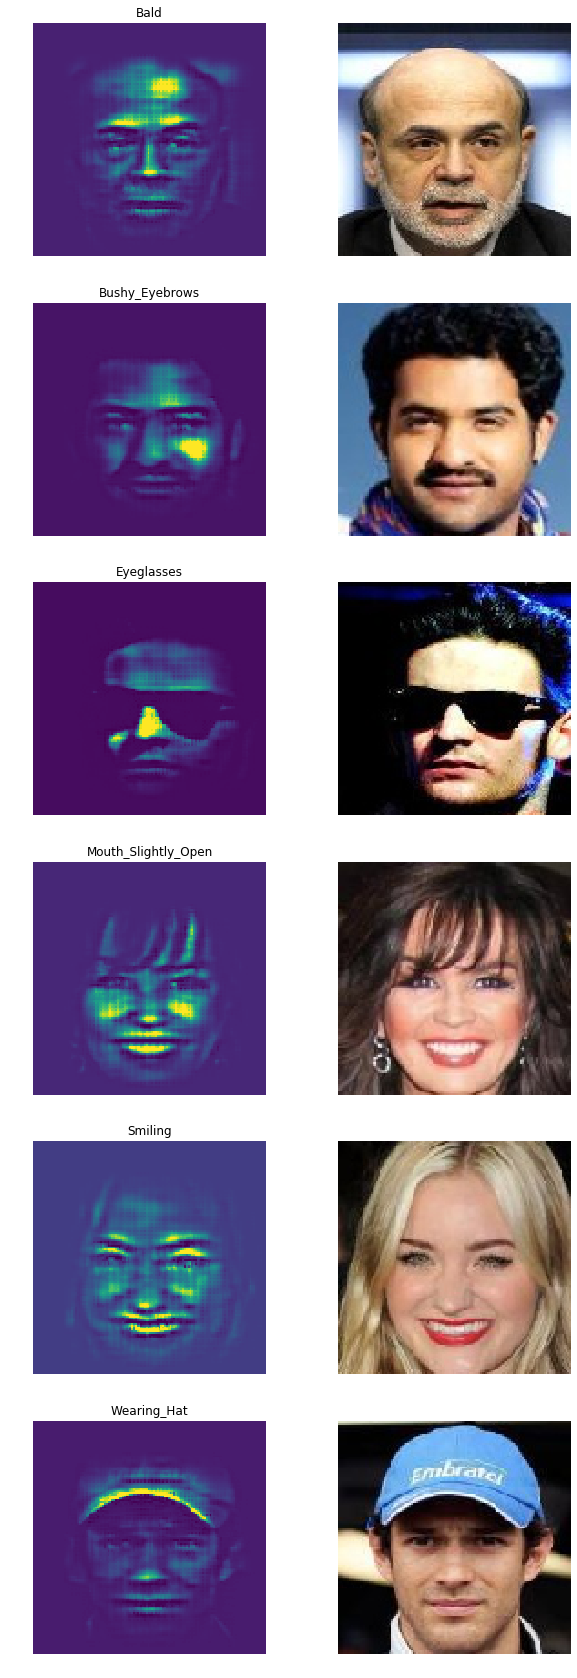

In [223]:
f, axs = plt.subplots(6,2,figsize=(10,30))

for j, attributions in enumerate(attributions_rect):
    axs[j,0].imshow(preprocess(attributions,0.5,99.5)[j])
    axs[j,1].imshow(img_array[j])
    axs[j,0].axis('off')
    axs[j,1].axis('off')
    axs[j,0].title.set_text(attributes[attr[j]])